In [124]:
# Miscellaneous
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans # Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Libraries for NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# custom methods
from utils import category_ngram, plot_history, plot_cmatrix, display_wordcloud, aut_frequency, plot_bars_authors

# Others
import os
import re

# Seaborn style
sns.set_style('whitegrid')
# Matplot style 
plt.style.use('ggplot')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sherlock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Dataset Description

The file contains 202,372 records. Each json record contains following attributes:

-  `category`: Category article belongs to
-  `headline`: Headline of the article 
-  `authors`: Person authored the article
-  `link`: Link to the post
-  `short_description`: Short description of the article
-  `date`: Date the article was published


# First Question

¿Se pueden catalogar las noticias con la descripción y los titulares? Compara tu
clasificación con las categorías incluidas en el set de datos.

Yes, it is possible to do such thing as the `description` and `headlines` can be used as features in a classification task where the targets are the `categories`. The next cells will attemp to adress this question.

The next step is to load the dataset

In [125]:
# Loading the dataset
news_category = pd.read_json('dataset/News_Category_Dataset_v2.json', lines=True)
# Shuffling the dataset (good practice)
news_category = news_category.sample(frac=1).reset_index(drop=True)
print('The dataset shape is {}'.format(news_category.shape))
news_category.head(10)

The dataset shape is (200853, 6)


,category,headline,authors,link,short_description,date
0,HOME & LIVING,"Bret Curtis, Race Car Driver Who Bought Lance ...",,https://www.huffingtonpost.com/entry/bret-curt...,** It's apparent Curtis has unbelievable taste...,2013-08-30
1,ENTERTAINMENT,John Travolta Sure Isn't Greased Lightning On ...,Ron Dicker,https://www.huffingtonpost.com/entry/john-trav...,"Sure, he's stayin' alive with 50 Cent rapping,...",2018-05-16
2,PARENTS,It's Been A Long Day (But Too Short Before Goo...,"Jennifer S. White, ContributorWriting, bloggin...",https://www.huffingtonpost.com/entry/its-been-...,It’s been a long day. Can you see me? I know y...,2017-03-20
3,POLITICS,Gusher Economics?,"Tom Engelhardt, ContributorEditor, TomDispatch...",https://www.huffingtonpost.com/entry/gusher-ec...,Isn’t it time to stop talking about “trickle d...,2017-11-28
4,TRAVEL,10 Luxury Islands That Are Surprisingly Afford...,Suzy Strutner,https://www.huffingtonpost.com/entry/live-on-a...,,2014-08-01
5,PARENTING,Power of Two,"Amanda Magee, Contributor\nSmall Business Owner",https://www.huffingtonpost.com/entry/power-of-...,"""If it's possible, Jeannie and I would like to...",2013-09-19
6,BLACK VOICES,Black Mother Speaks Out: African-American Boys...,Rahel Gebreyes,https://www.huffingtonpost.com/entry/parents-k...,,2014-08-22
7,WOMEN,One Food Has Gotten My Mother and Me Through E...,"Bustle, ContributorNews, entertainment, lifest...",https://www.huffingtonpost.com/entry/one-food-...,"Sometimes, it seems as though at every major m...",2014-05-12
8,RELIGION,Trump And The Catholic Schism,"Rosemary Westwood, ContributorColumnist and Wr...",https://www.huffingtonpost.com/entry/trump-and...,"No religion can survive long, or fruitfully, i...",2017-07-20
9,ENTERTAINMENT,Phish's Epic Run For The Ages,"Andrew Abramson, ContributorOpinion columnist",https://www.huffingtonpost.com/entry/phishs-ep...,Joe DiMaggio’s 56-game hitting streak. Michael...,2017-08-02


This dataset contains a total of 6 features and 200853 samples (which is a lot!).


For a further dig into the dataset, the function ``describe`` of pandas is used. There we can see samples the number of unique categories which are 41. Additionally, It is possible to see that there are repeated headlines, authord and short_descriptions. The last information will be used to filter the dataset.

In [126]:
# Describe info of the dataset
news_category.describe()

<ipython-input-126-c99a2d68ffff>:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://stylelike...,,2013-01-17 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


Another important step is to check for Null or NaN values. Although it was already seen with the `describe` method that there is not NaN, The following cell prints the sum of NaN in the dataset.

In [127]:
# Checking for NaNs
news_category.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

The next cell prints all the categories within the dataset, this is a very good insight about the number of categories and their names.

In [128]:
# Print unique categories
print('The Categories in the dataset are: \n')
print(news_category.category.unique())
print('The total number of features are: {}'.format(len(news_category.category.unique())))

The Categories in the dataset are: 

['HOME & LIVING' 'ENTERTAINMENT' 'PARENTS' 'POLITICS' 'TRAVEL' 'PARENTING'
 'BLACK VOICES' 'WOMEN' 'RELIGION' 'ARTS & CULTURE' 'STYLE & BEAUTY'
 'WELLNESS' 'FIFTY' 'QUEER VOICES' 'STYLE' 'WEDDINGS' 'THE WORLDPOST'
 'COLLEGE' 'HEALTHY LIVING' 'FOOD & DRINK' 'ARTS' 'BUSINESS' 'TECH'
 'COMEDY' 'SCIENCE' 'CRIME' 'TASTE' 'SPORTS' 'WORLDPOST' 'LATINO VOICES'
 'ENVIRONMENT' 'WORLD NEWS' 'DIVORCE' 'MEDIA' 'EDUCATION' 'CULTURE & ARTS'
 'IMPACT' 'WEIRD NEWS' 'GREEN' 'GOOD NEWS' 'MONEY']
The total number of features are: 41


From before we can see that there are a total of 41 unique categories in the dataset. These categories need to be processed to be used in further steps in a classifier.

To see what a `short_description` looks like, the next line prints one.

In [129]:
print('A short description: "{}"'.format(news_category.iloc[7]["short_description"]))

A short description: "Sometimes, it seems as though at every major moment of my life, cupcakes were present. They were eaten on every birthday and anniversary, each sick day and summer vacation. They were even in her hospital bag when I was born, smushed in between diapers and a change of clothes."


### Visualizing data

To gain more insights about the dataset, I will plot the number of samples belonging to an specific category in a barplot. This will plot will show if the datasetet is balanced.

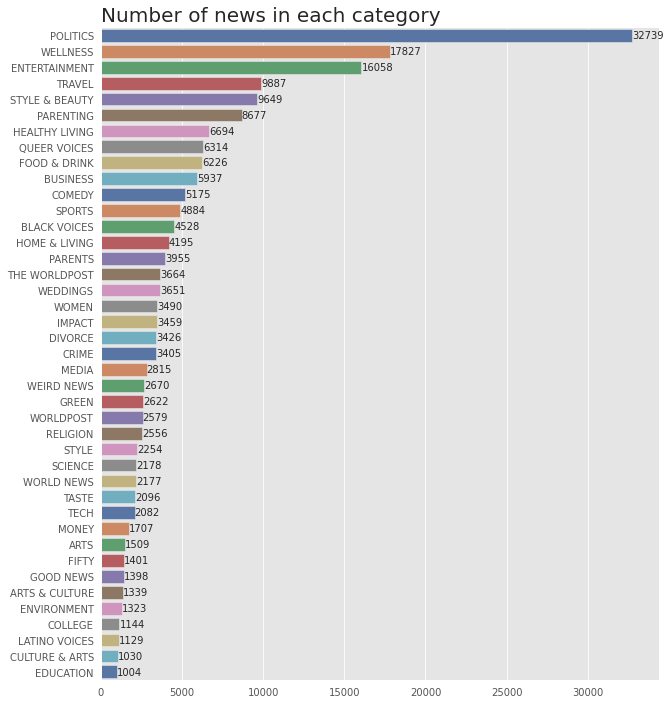

In [130]:
# Create new dataframe
bars_df = pd.DataFrame(news_category['category'].value_counts()).reset_index()
# Plotting
plt.figure(figsize=(10, 12))
bars = sns.barplot(data = bars_df, y = 'index', x = 'category', palette='deep')
plt.title('Number of news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
ax = bars
# Adding values in each bar 
# https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
    
plt.show()

From the last plot we can see that the `category` "Politics" is the most common one in the dataset. Moreover, the category with less samples is `Education`, however, it seems to be a reasonable value to train a neural network. The last Barplot give us considerable good insights about what are the most frequent categories in the dataset. Additionally the `categories` ranging from "Media" to "Education" have similar values which might useful to know before training a model.

Another interesting insight would be the average lenght of the `headlines` and `descriptions` in the dataset, to do so, a probability, dense function will be plotted for each of these features.

In [131]:
# Use plotly to see the distribution of categorical data
# https://www.kaggle.com/vikashrajluhaniwal/recommending-news-articles-based-on-read-articles#6.-Headline-based-similarity-on-new-articles
fig = ff.create_distplot([news_category['headline'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Headline lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of a headline",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500)
plotly.offline.plot(fig, filename = 'headline.html')

'headline.html'

The last plot shows the univariate or bivariate distribution with a kernel density estimate. This plot is useful as it presents how are distributed the lenght of the `headline` feature. In fact, most of the text in this feature is condensed between 90 and 70 characters lenght. Therefore, if we were going train a model using only this feature, there would be approximately 80 characters-long. 

Similarly, it is also possible to plot the lenght of the `short_description`.

In [132]:
# Use plotly to see the distribution of categorical data

fig = ff.create_distplot([news_category['short_description'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Description lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of Description",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500)
plotly.offline.plot(fig, filename = 'short_description.html')

'short_description.html'

The text-lenght for the `short_description` feature is roughly 200 characters long. It is also possible to see that the text's average lenght in the `headline` and in the `short_description` are quite different. Generally, the text in the description is way longer and may provide more information for a classification task.

### Filtering the dataset

The following cells will be used to filter the text within the `headline` and `short_description` features. 

These lines of code are for testing purpose, and filter the dataset based on the most recent data. This is done due to computational resources as working with the whole dataset might be extremely slow. I will use data ranged only from 2017/05/05 and above. The resulting dataset will be stored in a different dataframe called `news_articles`.

In [133]:
# Filter dataset by date
f_articles = news_category[news_category['date'] >= pd.Timestamp(2017,5,5)]
#f_articles = news_category.copy()
print('The shape of the filtered dataset is: {}'.format(f_articles.shape))

The shape of the filtered dataset is: (27487, 6)


One drawback from the past lines are that the dataset now has less categories. To validate this, the next cell prints the new list of categories.

In [134]:
# Print unique categories
print('The Categories in the dataset are: \n')
print(f_articles.category.unique())
print('The total number of features are: {}'.format(len(f_articles.category.unique())))

The Categories in the dataset are: 

['ENTERTAINMENT' 'POLITICS' 'RELIGION' 'QUEER VOICES' 'SPORTS' 'COMEDY'
 'PARENTS' 'LATINO VOICES' 'WORLD NEWS' 'EDUCATION' 'WEIRD NEWS' 'COLLEGE'
 'WOMEN' 'BUSINESS' 'MEDIA' 'BLACK VOICES' 'ARTS & CULTURE'
 'HEALTHY LIVING' 'CRIME' 'STYLE' 'TASTE' 'IMPACT' 'TRAVEL' 'GREEN'
 'SCIENCE' 'THE WORLDPOST' 'GOOD NEWS' 'TECH']
The total number of features are: 28


Our new sampled dataset now has only 28, in comparison agains the whole dataset with 41 categories.

An important step is to remove headlines and descriptions with less than five words. Additionally, as mentioned before there are repeated headlines and short descriptions, thus, it is neccessary to remove these repeated texts.

In [135]:
# Filter headlines with less than 5 characters
f_articles = f_articles[f_articles['headline'].apply(lambda x: len(x.split())>5)]
f_articles = f_articles[f_articles['short_description'].apply(lambda x: len(x.split())>5)]
# Filter headlines in a descending manner
f_articles.sort_values('headline',inplace=True, ascending=False)
# Make a copy of the dataset
duplicated_headlines_series = f_articles.duplicated('headline', keep = False)
# Remove repeated headlines 
news_articles = f_articles[~duplicated_headlines_series]
# Make another copy of the dataset
duplicated_description_series = f_articles.duplicated('short_description', keep = False)
# Remove repeated descriptions 
news_articles = f_articles[~duplicated_description_series]
print("Total number of articles after removing duplicates (headlines):", f_articles.shape[0])

Total number of articles after removing duplicates (headlines): 24274


In [136]:
print("Total number of articles : ", f_articles.shape[0])
print("Total number of authors : ", f_articles["authors"].nunique())
print("Total number of unqiue categories : ", f_articles["category"].nunique())

Total number of articles :  24274
Total number of authors :  3922
Total number of unqiue categories :  28


After filtering, we ended up with 24274 samples which are 3213 less samples than the ones we originally had.

It is interesting to visualize the number of articles per date, the next cell shows the aforementioned.

In [137]:
# Articles per month
news_articles_per_month = f_articles.resample('m', on = 'date')['category'].count()
news_articles_per_month

date
2017-05-31    2006
2017-06-30    2273
2017-07-31    2129
2017-08-31    2254
2017-09-30    2027
2017-10-31    2084
2017-11-30    1934
2017-12-31    1765
2018-01-31    1856
2018-02-28    1543
2018-03-31    1652
2018-04-30    1480
2018-05-31    1271
Freq: M, Name: category, dtype: int64

From the past cell, I can conclude that the data is well distributed among the given dates.

Now is time to remove the stopwords, as this is a dataset in English, I will use the stopwords provided in the library `stopwords`

In [138]:
# remove stop words
stop_words = set(stopwords.words('english'))
# List of stopwords to filter
print(stop_words)

{'y', 'then', 'being', 'ma', 'them', 'been', 'while', 'shan', "that'll", 'd', 'and', 'i', 'him', 'above', 'where', 'yours', 'we', 'between', 'no', 'any', 'doesn', 'itself', 'what', 'does', 'm', "needn't", 'own', 'wouldn', 't', 's', 'has', 'with', 'other', "aren't", 'ourselves', 'me', 'myself', 'here', 'do', 'or', "you'd", 'off', 'couldn', 'can', "shan't", 'all', 'is', "couldn't", 'himself', 'an', 'ain', 'before', "mightn't", 'herself', "hadn't", 'll', 'because', "weren't", 'won', 'its', "hasn't", 'about', 'needn', 'will', 'out', 'few', 'she', 'mustn', 'after', 'my', 'again', 'why', 'haven', 'her', 'in', 'so', 'your', 'these', "she's", 'than', 'did', 'under', 'shouldn', 'o', 'over', 'theirs', 'down', "wasn't", 'most', 'against', "didn't", 'had', 'once', 'more', "should've", 'yourself', 'during', 'at', 'their', 've', 'how', 'there', "it's", 'when', 'am', 'too', 'if', 'whom', 'hasn', 'weren', 'further', 'below', 'as', "doesn't", 'having', "won't", 'who', 'not', 'were', 'it', 'nor', 'you',

The following functions are used to create some filters for the dataset. The method `remove_stopwords` is used to remove stop words, `alpha_num` removes any character that is not alphanumeric, finally, `rem_lemmatizer` converts the words to its base form. These three basic filters are extremely useful when processing text within a dataset and can considerable improve performance.

In [139]:
# Removing stopwords
def remove_stopwords(text):
    final_text = []
    # Split text
    for i in text.split():
        # Check if word is not in stopword, otherwise do not append
        if i.strip().lower() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

In [140]:
# Remove non alphanumeric characters
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

In [141]:
# Lemmatize words to its base form
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
lemmatizer = WordNetLemmatizer()
def rem_lemmatizer(text):
    final_text = []
    string_l = ""
    for w in word_tokenize(text):
        string_l += lemmatizer.lemmatize(w, pos = "v") + " "
    final_text.append(string_l.strip())
    return " ".join(final_text)

Once our filters are defined it is time to apply it to the dataset to the `headline`, `short_description` and `category` features. One step that is doing inplace is to convert all the caracters to lowercase. When the dataset is showed, it is possible to validate how all the filters are successfully parsed applied.

In [142]:
# Headline filtering
# Lowercase
f_articles['headline'] = f_articles['headline'].str.lower()
# Remove stopwords
f_articles['headline'] = f_articles['headline'].apply(remove_stopwords)
# Remove non alphanumerics
f_articles['headline'] = f_articles['headline'].apply(alpha_num)
# Lemmatizer
f_articles['headline'] = f_articles['headline'].apply(rem_lemmatizer)

# Description filtering
f_articles['short_description'] = f_articles['short_description'].str.lower()
f_articles['short_description'] = f_articles['short_description'].apply(remove_stopwords)
f_articles['short_description'] = f_articles['short_description'].apply(alpha_num)
f_articles['short_description'] = f_articles['short_description'].apply(rem_lemmatizer)
# Category (lowercase)
f_articles['category'] = f_articles['category'].str.lower()

f_articles.head()

,category,headline,authors,link,short_description,date
84244,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18
110889,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02
126337,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31
76563,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19
87332,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20


Now it is time to define the features that are going to be Tokenized. There are two ways to do such thing. The **first** one is to Tokenize each feature (with same vectore lenght) and then concatenate the vectors. The **second** option is to blend the strings into a longer one and thus, avoiding the need of two tokenization steps. Based on my analysis I decided to use the second opion.

To simplify the problem the `headline` and `short_description` text are blended together and used as a unified feature. This new feature is called `full_text`.

In [143]:
# Combining text
f_articles["full_text"] = f_articles["headline"].map(str) + " " + f_articles["short_description"]
f_articles.head()

,category,headline,authors,link,short_description,date,full_text
84244,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18,to bone didnt teach glamour teach respect ofte...
110889,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02,will grace creator donate gay bunny book every...
126337,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31,we blood invisible live indias dalit women gir...
76563,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19,wannacry ransomware attack raise alarm bell ci...
87332,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20,walk dead reportedly cancel comiccon press eve...


The dataframe presented above has one additionall feature as expected.

An example of how a full text looks like is shown below.

In [144]:
print('The fused text is: "{}"'.format(f_articles.iloc[0]["full_text"]))

The fused text is: "to bone didnt teach glamour teach respect oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance"


It is also important to see the most common words based on a particle category. To do so, the method `category_ngram` prints the top-10 most frequent words of a given category (the method arguments can be different as will be showed in further cells).

In [145]:
# Printing top-10 most frequent words in category 'politics'
category_ngram('politics', 1, f_articles, 'category', 'headline')

,index,frequency
0,trump,3228
1,say,609
2,donald,549
3,gop,452
4,house,423
5,white,367
6,us,357
7,new,333
8,health,305
9,bill,296


### Tokenizing data

Now it is time to parse the data for the classification Task, the first part is to convert the data into numpy arrays. The target will be the `categories` and the features the `headline` and `short_description` blended in the `full_text` feature.

In [146]:
# Targets
seq_text = np.array([text for text in f_articles['full_text']])
# Labels
labels = np.array([label for label in f_articles['category']])

Now we will print the shape of `seq_text` which should has dimensions equal to the number of samplesin the dataframe

In [147]:
# Printing the shape and a text 
print('The shape of the numpy array is: {}'.format(seq_text.shape))
print('The shape of the dataframe is: {}'.format(f_articles.shape))
print('A text example: "{}"'.format(seq_text[0]))

The shape of the numpy array is: (24274,)
The shape of the dataframe is: (24274, 7)
A text example: "to bone didnt teach glamour teach respect oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance"


### Encoding the data

Now comes one of the most important steps and this is the encoding of the labels. As the Labels of this problem are categorical, we need to create a numeric representation. To do so, `sklearn` LabelEncoder is employed. This method assign a unique class label per each categoric feature. As we have 28 features we expect labels ranging from 0 to 28.

In [148]:
# Encoding categories
label_encoder = LabelEncoder()
# Fir the encoder
labels = label_encoder.fit_transform(labels)

The lenght of the labels must match the lenght of the catories. This information is verifies below. 

In [149]:
print('The lenght of the labels are: {}'.format(len(np.unique(labels))))
print('The labels are: {}'.format(np.unique(labels)))

The lenght of the labels are: 28
The labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


The following lines define the model's parameters overall these are given as follows.

-  vocab_size: the lenght of the vocabulary
-  embedding_dim: The size of the embedding dimension
-  lstm_dim: Number of LSTM units
-  hidden_dim: Number of hidden units (Dense layers)
-  max_length: The maximum lenght of the tokenize word
-  padding_type: Where to pad the vector, after or before
-  oov_tok: Token used to replace out-of-vocabulary of the words

In [150]:
# Parameters
# Size of the vocabulary
vocab_size = 2000
# Dimmension of the embedding 
embedding_dim = 128
# LSTM dim
lstm_dim = 32
# hidden dim (fully connected)
hidden_dim = 64
# Maximum lenght of the tokenized vector
max_length = 120
# Padd the vector after the sequence
padding_type ='post'
# Used to replace out-of-vocabulary words
oov_tok = "<OOV>"

Here is the `train_test_split` of the dataset to have a validation dataset. The 30% of the dataset will be used for validating the final results.

In [151]:
# split the dataset
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(seq_text, labels, 
                                                                                          test_size=0.3, 
                                                                                          stratify=labels)

In [152]:
print('The lenght of the training set is: {}'.format(train_sentences.shape))
print('The lenght of the validation set is: {}'.format(validation_sentences.shape))

The lenght of the training set is: (16991,)
The lenght of the validation set is: (7283,)


Here is where the magic happens and the words are tokenized. To do so, Keras' Tokenizer method is used. This method will automatically create the tokenized vectors with a specified lengh, padding method, etc. It is important to recall that all the parameters were set before, if you forget it go up and take a look!

In [153]:
# Transform text into a vector
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fir to the train sequence
tokenizer.fit_on_texts(train_sentences)
# Dictionary with the index of each word
word_index = tokenizer.word_index

# Transform train dataset to sequence 
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# Pad the sequence to the desired shape (given above)
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)

# Vectorize and Padd validation dataset
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen = max_length)

In [154]:
print('The shape of the tokenized validation dataset is: {}'.format(validation_padded.shape))

The shape of the tokenized validation dataset is: (7283, 120)


From above we can see that the tokenized vector has the desired lenght (120) and the number of samples equal the number of samples before the tokenization.

### Defining and training the model


Here is defined a simple model to classify the categories in the dataset. Recall that the features `headline` and `short_description` were blended into one single feature called `full_text`. The objective here is to classify the category given the previuos information. 

The model defined is a neural network with one embedding layer and 3 fully connected layers. Between the Embedding and the Fully connected layers is a `GlobalAveragePooling1D` which drops the sequence dimension in the output of the Embedding layer.

As this is a multiclassification task, the crossentropy loss is used, the optimizer is adam and the metric used to evaluate the model is the accuracy. A model description is provided in the cell below.

I also defined an early stop call which stops the training if the validation loss starts decreasing.

**Note**: Below is another model with a Bidirectional LSTM, so recall to just use the cell of the model you want to use.

**Note**: I defined two simple models, however, higher complexity strategies could be used as convolutions or attention.

In [155]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Flat Dimension
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(hidden_dim * 2, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 128)          256000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 28)                3612      
Total params: 276,188
Trainable params: 276,188
Non-trainable params: 0
_________________________________________________________________
None


### Defining and training a model with a Bidirectional RNN

This implementation has a `Bidirectional` LSTM layer. This particular layer basically makes a copy of the orinal LSTM and processes the information in backwards order. It is important to take into consideration that if the number of LSTM units are 8 the `Bidirectional` will make a copy and therefore, we will end up with a total of 16 LSTM units. Afterwarrds, the model has two Dense layers (one less than the previous model). The loss function, optimizer and metrics are the same as the ones used with the last model.

In [122]:
# Model definition

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    # Flat Dimension
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)), # Output of LSTM is Batch x Net out x 2
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 128)          256000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 28)                1820      
Total params: 303,196
Trainable params: 303,196
Non-trainable params: 0
_________________________________________________________________
None


### Training

With the model ready, it is time to train. The next lines train the model for a given number of epochs. It is very important to mention that an early stop call was set. Once the sub-validation test' accuracy starts decreasing per 3 consecutive epochs, the model will stop training. The 20% of the training data is used to measure how good the model is performing on unseen data.

In [156]:
# Callback for early stopping after val stop improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
num_epochs = 50
history = model.fit(train_padded, train_labels, 
                    epochs = num_epochs, verbose=2, 
                    validation_split=0.2, callbacks= [early_stop])

# Predict over the validation test
pred_val = model.predict(validation_padded)
pred_val = np.array([np.argmax(i) for i in pred_val])

Epoch 1/50
425/425 - 2s - loss: 2.4507 - accuracy: 0.3637 - val_loss: 2.1963 - val_accuracy: 0.4334
Epoch 2/50
425/425 - 2s - loss: 2.1190 - accuracy: 0.4372 - val_loss: 2.0732 - val_accuracy: 0.4478
Epoch 3/50
425/425 - 2s - loss: 2.0169 - accuracy: 0.4540 - val_loss: 2.0218 - val_accuracy: 0.4522
Epoch 4/50
425/425 - 2s - loss: 1.9331 - accuracy: 0.4703 - val_loss: 1.9469 - val_accuracy: 0.4725
Epoch 5/50
425/425 - 2s - loss: 1.8193 - accuracy: 0.4987 - val_loss: 1.8937 - val_accuracy: 0.4887
Epoch 6/50
425/425 - 2s - loss: 1.7381 - accuracy: 0.5151 - val_loss: 1.8489 - val_accuracy: 0.5013
Epoch 7/50
425/425 - 2s - loss: 1.6575 - accuracy: 0.5433 - val_loss: 1.7835 - val_accuracy: 0.5287
Epoch 8/50
425/425 - 2s - loss: 1.5655 - accuracy: 0.5703 - val_loss: 1.7679 - val_accuracy: 0.5393
Epoch 9/50
425/425 - 2s - loss: 1.4916 - accuracy: 0.5859 - val_loss: 1.6992 - val_accuracy: 0.5499
Epoch 10/50
425/425 - 2s - loss: 1.4248 - accuracy: 0.6011 - val_loss: 1.6917 - val_accuracy: 0.5616

As shown above, the model was successfully trained, for a deeper dive I will plot the Losses and Accuracy of the training.

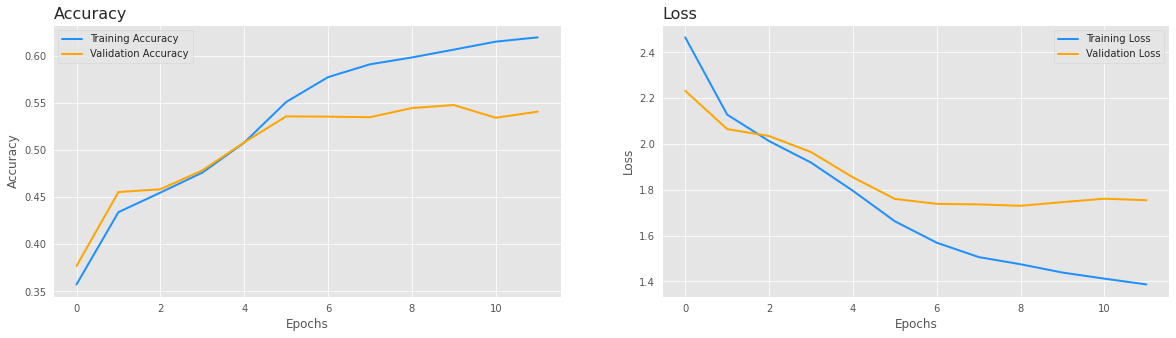

In [34]:
# Plotting the history of the model
plot_history(history)

It is important to see how the model stopped once the validation loss stopped improving, preventing overfitting in the given model. I tried training this model for more epochs, but with both models, the result was overfitting. 

**Note** The model with the Bidirectional layer performed just 0.05% better in the validation test than the fully connected one. Thus, I decided to move forwards with the simplest.

It is also important to plot the confusion matrix of the validation text. This information will tell us how good the model is performing on unseen data (validation dataset).

The overall training accuracy is: 0.5345324728820541


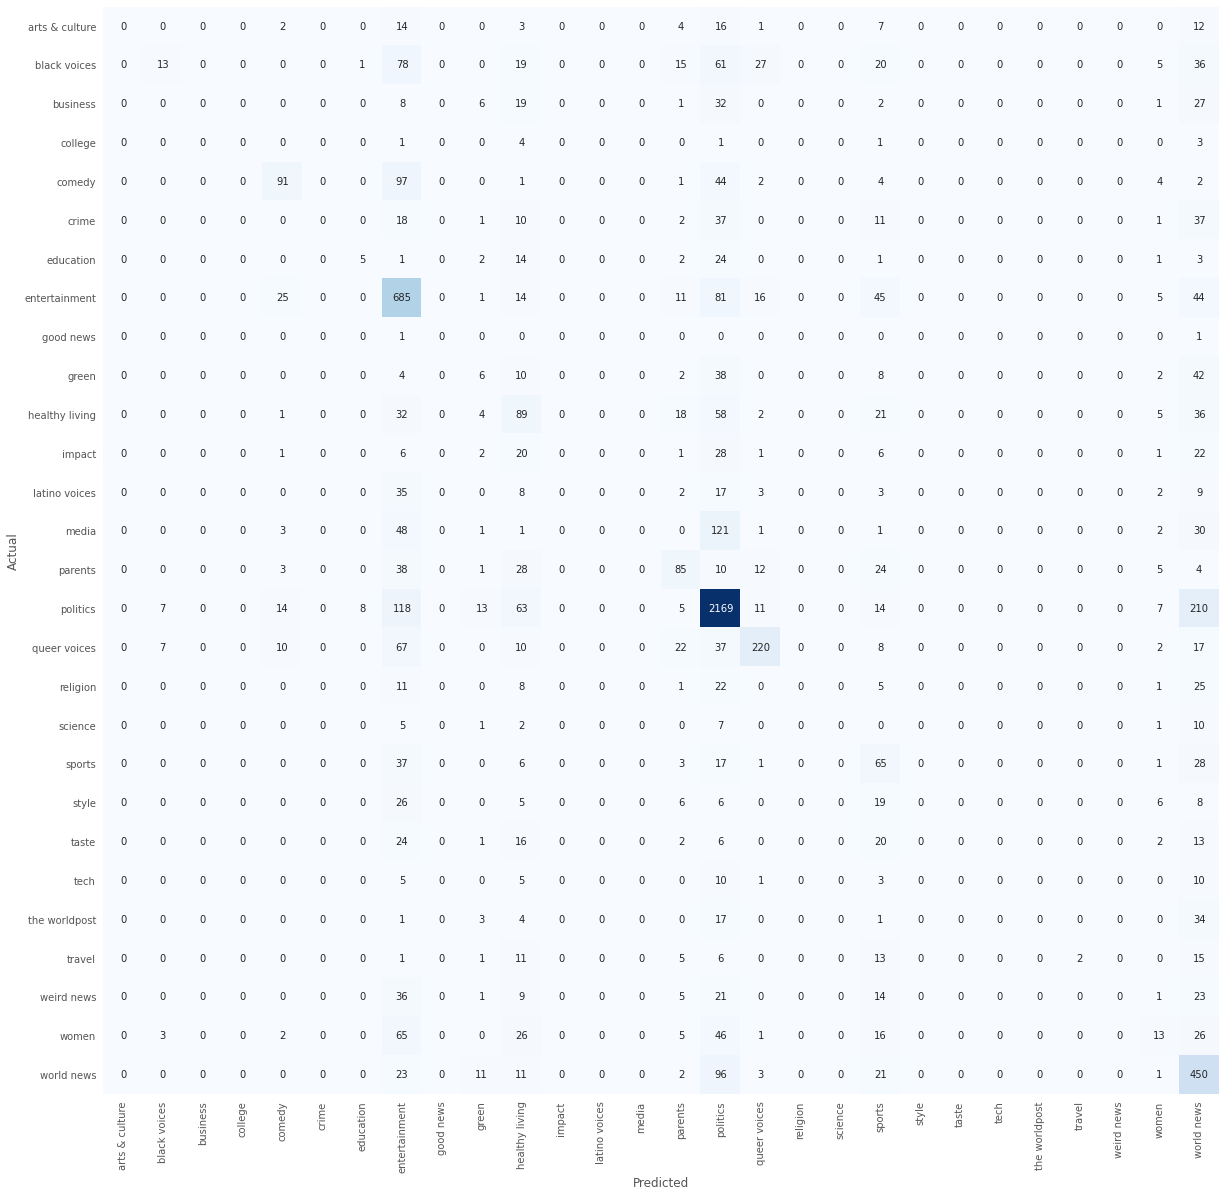

In [35]:
# Confusion matrix
# label_encoder.classes_ show the classes encoded
print('The overall training accuracy is: {}'.format(accuracy_score(pred_val, validation_labels)))
plot_cmatrix(pred_val, label_encoder.classes_, 20, validation_labels)

The overall accuracy in the validation set was of 0.554% and 0.6566% for the training set. This is not a perfect result but is good for such simpler model. To improve these results, It might be possible to increase the complexity of the model with regularization techniques. The aforementioned would allow the improvement of the model's accuracy. Similarly, the confusion matrix shows how the `categories` "politics", "entertainmente" and "world news" were the ones with the best classification results. For the first two categories mentioned, the categories "politics", "entertainmente" possesses a broader number of samples, resulting in more examples for this particular class. It is possible to see how there are categories like "the worldpost" or "travel" that never had a match. The information previously mentiones is result of the imbalance in the dataset, particularly, the imbalance in our small subset of data.

More metrics are printed below. These are the Precision, Recall, F1-Score and Support. This information complements the confusion matrix and allows for a deeper analysis.

In [36]:
# Printing all the metrics
print(classification_report(pred_val, validation_labels, target_names = label_encoder.classes_))

                precision    recall  f1-score   support

arts & culture       0.00      0.00      0.00         0
  black voices       0.05      0.43      0.09        30
      business       0.00      0.00      0.00         0
       college       0.00      0.00      0.00         0
        comedy       0.37      0.60      0.46       152
         crime       0.00      0.00      0.00         0
     education       0.09      0.36      0.15        14
 entertainment       0.74      0.46      0.57      1485
     good news       0.00      0.00      0.00         0
         green       0.05      0.11      0.07        55
healthy living       0.33      0.21      0.26       416
        impact       0.00      0.00      0.00         0
 latino voices       0.00      0.00      0.00         0
         media       0.00      0.00      0.00         0
       parents       0.40      0.42      0.41       200
      politics       0.82      0.72      0.77      3028
  queer voices       0.55      0.73      0.63  

/home/sherlock/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Besides the last metrics, I wanted to see the number of good classifications per class, to do so the following cell print the results.

In [37]:
class_correct = list(0. for i in range(len(np.unique(labels))))
class_total = list(0. for i in range(len(np.unique(labels))))
# For loop to count the number of matches per class
for i in range(len(validation_labels)):
    # current target's label
    label = validation_labels[i]
    if validation_labels[i] == pred_val[i]:
        class_correct[label] += 1
    # Sum label
    class_total[label] += 1
        
for i in range(len(np.unique(labels))):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(label_encoder.classes_[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Accuracy of arts & culture:  0% ( 0/59)
Test Accuracy of black voices:  4% (13/275)
Test Accuracy of business:  0% ( 0/96)
Test Accuracy of college:  0% ( 0/10)
Test Accuracy of comedy: 36% (91/246)
Test Accuracy of crime:  0% ( 0/117)
Test Accuracy of education:  9% ( 5/53)
Test Accuracy of entertainment: 73% (685/927)
Test Accuracy of good news:  0% ( 0/ 2)
Test Accuracy of green:  5% ( 6/112)
Test Accuracy of healthy living: 33% (89/266)
Test Accuracy of impact:  0% ( 0/88)
Test Accuracy of latino voices:  0% ( 0/79)
Test Accuracy of media:  0% ( 0/208)
Test Accuracy of parents: 40% (85/210)
Test Accuracy of politics: 82% (2169/2639)
Test Accuracy of queer voices: 55% (220/400)
Test Accuracy of religion:  0% ( 0/73)
Test Accuracy of science:  0% ( 0/26)
Test Accuracy of sports: 41% (65/158)
Test Accuracy of style:  0% ( 0/76)
Test Accuracy of taste:  0% ( 0/84)
Test Accuracy of  tech:  0% ( 0/34)
Test Accuracy of the worldpost:  0% ( 0/60)
Test Accuracy of travel:  3% ( 2/54)
T

To summarize, the last cell presented the number of matches per class giving the total number of samples. This information allows for a better understanding of the model and its performance. It also confirms how the model classified the `category` "politics" with the highest accuracy (84%). From this analysis I conclude that the model is capable to classify the sub-sampled dataset with roughly a 55% of accuracy. Further improvements as the ones mentioned avobe could be applied for further developments.

# Second point

¿Existen estilos de escritura asociados a cada categoría?

To analize the writing style of the authors, I will use a wordCloud's plot. With this cloud I pretend to analize the top 10 most used words by `category` and thus give insights about the writing styles. I consider that this is a very simple approach as it relates the writing style to the words used in a text. For example, I use a lot the word "insight", that word is in my writing style and therefore might be considered as a key factor to analize this question. Based on the last analysis I aim to find the most used words in each category. However, complex analysis should be performed as analyzing the structure of the writing, word order, etc.

A fancier approach would be to use a Neural network to generate text giving it a particular category. The generated text should have a particular style based on the category, however, I do not have enough time to implement it :(

First of all, I will list all the authors in the dataframe.

In [38]:
# Make a copy of the dataset
category_df = f_articles.copy()

print('The Categories in the dataset are: \n')
# Obtain unique categories
categories = category_df.category.unique()
print(categories)
print('The total number of features are: {}'.format(len(categories)))

The Categories in the dataset are: 

['healthy living' 'queer voices' 'world news' 'politics' 'entertainment'
 'comedy' 'black voices' 'green' 'impact' 'latino voices' 'business'
 'women' 'weird news' 'taste' 'crime' 'media' 'parents' 'travel'
 'arts & culture' 'tech' 'education' 'sports' 'religion' 'science' 'style'
 'the worldpost' 'college' 'good news']
The total number of features are: 28


Now I will count the number of times a particular category is repeated in the dataset. 

In [39]:
# Counting unique items
item_counts = category_df[["category"]].value_counts(sort=True).reset_index()
# Drop annoyng index
print(item_counts[:10])

         category     0
0        politics  8797
1   entertainment  3089
2      world news  2061
3    queer voices  1332
4    black voices   916
5  healthy living   886
6          comedy   821
7         parents   699
8           media   694
9           women   678


This information printed above relates to the analysis performed in the previous task as "politics" is the most frequen category folllowed by "entertainment".

Now I will used the method `category_ngram` to see the most used words in the category "politics" To do this analysis, I will dig in our custom feature "full_text" as this might have more useful text information.

In [40]:
# Counting repeated words in the politics category
cat_df = category_ngram('politics', 1, category_df, 'category', 'full_text')
# Transforming the result in a tuplr for visualization purpose
cat_tuple = [tuple(x) for x in cat_df.values]
print(cat_df)

       index  frequency
0      trump       4634
1        say       1985
2  president        971
3      state        838
4     donald        833
5      house        828
6         us        780
7      white        724
8        new        721
9        gop        634


It is ironic to see how the top-3 most frequent words in the category "politics" are "Trump", "say" and "president". This makes a lot of sense as the "politics" category must be talking about presidents, states and so on. Moreover, the other frequent words are strongly related to "politics". The conclusion of this short analysis is that most of the writters of the "politics" category share the common words mentioned above and probably, their writing style is very similar.

Now I want to show a word cloud for the previous category. This is done through the next cell.

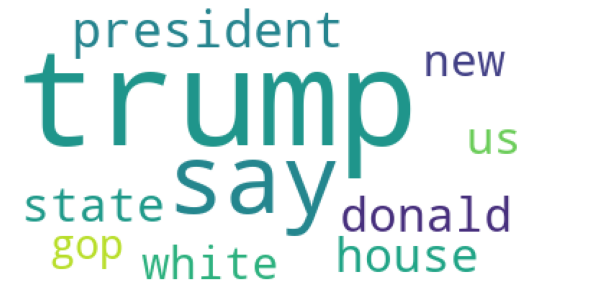

In [41]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words = 200, background_color ='white', stopwords = stop_words).generate_from_frequencies(dict(cat_tuple))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

This is the same information as the one printed earlier for the category "politics" however, it is important to visualize it in a aesthetic way. 

Now is time to think bigger. Due to the amount of categories in our sampled dataset (28), I decided to create a word cloud for the 12 more frequent categories. This is performed following similar steps as the ones carried out. To clean the code, the whole method is implemented in `display_wordcloud`.

/home/sherlock/Desktop/whale_jaguar_test/utils.py:77: MatplotlibDeprecationWarning:

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.



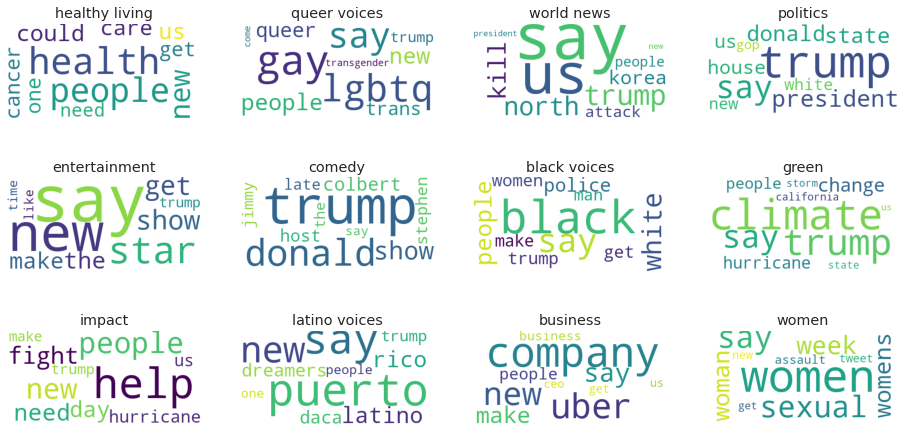

In [42]:
# Display 12 word clouds with the top-10 most used categories of the top-12 most frequent categories.
display_wordcloud(category_df, stop_words, 12, feature2filter = 'category', varText = 'full_text')

I will analyse some of the styles presented above, however, there is a lot to do! I will not analyze again the style in "politics" as this was already discussed. Nevertheless, It is important to mentiones that the words "trump" and "donal" are also used in the category "comedy". This is due to the number of comediands that like to joke about Trump (which is actually funny). A really interesting insight about the aforementioned is that the writing style of politicians share in common some words, which is indeed interesting.

Now, the writing style of "latino voices" has some words in spanish such like "puerto", "rico" and "latino". Maybe, the writters of this category think that most of the latinos are from Puertorico, which end up being a writing style among the writers of the "latino voices"' category (Trump is also there). Something interesting happens with the category "women" as besides the common words "women", "woman" there are also some like "assault" and "sexual". The past words portraits how the writers of the "women" category use a lot the words "assault" and "sexual" which in my opinion, is not a good thing.

The category "health living" use common words related to health talks which is not surprising at all, as the writing style of its authors shoulg contain these words. Another interesting one is "queer voices" and the use of words like "gay", "lgbtq", "trans". The last pattern show how most of the text of this category has to contain this words... a very particular writing style indeed.

I could go further but there is a lot to say. I hope that the last analysis let the idea behind the writing analysis based on words clear.

# Third Point

¿Qué se puede decir de los autores a partir de los datos?

To dig into this point I will use the word cloud used before, as in my opinion, authors might share writing styles (words). Finally, a barplot with the top-3 most used words by author will be used to finish the analysis.

The first step is to trim the strings in the `authors` column. This is for visualization purposes as some authors have strings with more than 80 characters. Authors are almost always in the first part of the sequence, separed by a comma of the rest of the text. Therefore, I will split the text and use only the text before the comma as the author.

In [43]:
# Removing long sequences of authors
def trim_string(text):
    # Obtain only the first element in the authors' column
    splitted_text = text.split(',')[0]
    return splitted_text

Some filtering is required as there are some `authors`' row with empty spaces. Additionally, the aforementioned filter is applied.

In [44]:
# Make a copy of the dataset
authors_df = f_articles.copy().reset_index(drop=True)

authors_df['authors'] = authors_df['authors'].apply(trim_string)
# Remove empty strings
authors_df['authors'].replace('', np.nan, inplace=True)
authors_df.dropna(subset=['authors'], inplace=True)

print('The Authors in the dataset are: \n')
authors = authors_df.authors.unique()
print(authors)
print('The total number of features are: {}'.format(len(authors)))

The Authors in the dataset are: 

['Mycah Hazel' 'Elyse Wanshel' 'Sara Hylton' ... 'Phu Nguyen'
 'Emily Kalah Gade' 'Anna Sabino']
The total number of features are: 3758


After filtering the dataset we end up with 3758 unique authors, which is a lot. To analize a little bit more, I will show the most frequent authors in the dataset.

In [45]:
# Count number of times an author is repeated
authors_count = authors_df[["authors"]].value_counts(sort=True).reset_index()
# Check first 10 sampples
print(authors_count[:10])

               authors    0
0            Lee Moran  906
1       Mary Papenfuss  601
2             Ed Mazza  576
3           Ron Dicker  554
4       Curtis M. Wong  427
5       Jenna Amatulli  393
6           David Moye  386
7      Rebecca Shapiro  327
8  Dominique Mosbergen  321
9          Doha Madani  298


It is interesting to see how "Lee Moran" is the most frequen author followed by "Mary Papenfuss" and so on. Besides the big diversity of authors in the dataset (rougly two authors per samples) the author "Lee Moran" is presented in approximately "906" samples. This value is around the 12% of all the samples in the dataset by means, a lot. A first conclusion would be that regardless of the huge amount of authors, there are some "key" authors that are presented in most of the samples. Therefore, I will analyze the top-8 most frequent authors in a barplot. But first, I will analyze 12 random authors using a word cloud through the same method `display_wordcloud` used in the past task.

/home/sherlock/Desktop/whale_jaguar_test/utils.py:77: MatplotlibDeprecationWarning:

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.



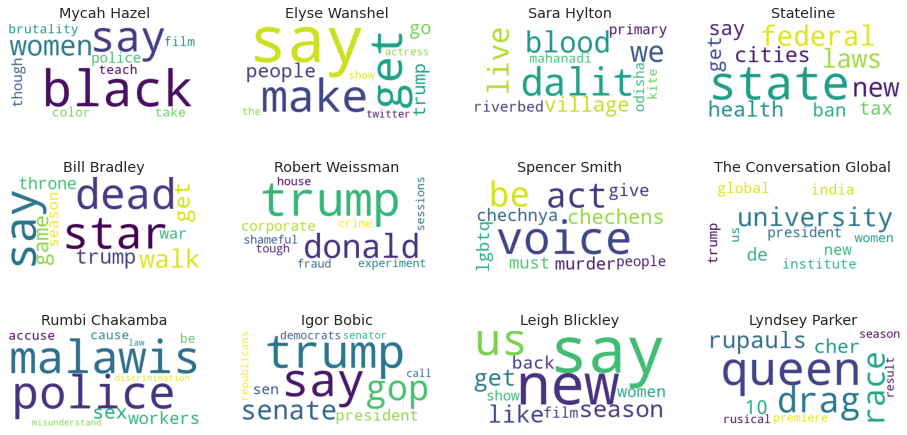

In [46]:
# WordCloud for the top 12 most common authors
display_wordcloud(authors_df, stop_words, 12, feature2filter = 'authors', varText = 'full_text')

Analyzing the 12 random giving the whole `headline` and `short_description`, it is possible to see common patterns as the ones analyzed before. For example, The author "Igor Bobic" seems to use a lot the word "trump", "senator", "say", "democrats" which are common words for the "politics" `category`. In a similar fashion, analysing the words of "Lyndsey Parker" is it possible to see writing patterns towards the "queer voices" category. Further analysis could be done, however an image is worth ten thousand words :).

As a quick conclusion, it is possible to see common writing styles and words among authors. It might be possible to classify the authors analyzing its words or even generate text based on the author's name. Different authors share common words which might be understood as they write in the same or similar categories.

To give more insights about the authors, I will print a bar plot with the top 3 most used words by author. The authors in this barplot will be the most frequent ones in the dataset.

The next cell of code shows the common words for a given author.

In [47]:
# Displaying common words of 'Mary Papenfuss' and frequency
aut_df = category_ngram('Mary Papenfuss', 1, authors_df, 'authors', 'full_text')
aut_df

,index,frequency
0,trump,307
1,say,209
2,president,53
3,call,51
4,donald,49
5,house,47
6,white,45
7,report,44
8,new,43
9,go,39


Now I will create a custom dataframe with the most common words used by the top-u most frequent authors and its frequency. To do so, the method `aut_frequency` is employed. This method returns a pandas dataframe as shown below.

In [48]:
# Create dataframe with words' frequency per author
aut_words_df = aut_frequency(iterations = 8, authors_name_dic = authors_count, full_authors_df = authors_df, max_words = 3)
aut_words_df

,authors,trump,donald,get,say,president,host,show,new,gay,people,man,news
0,Lee Moran,485,288,105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mary Papenfuss,307,0,0,209.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ed Mazza,281,0,0,90.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ron Dicker,0,0,55,152.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0
4,Curtis M. Wong,0,0,0,101.0,0.0,0.0,0.0,95.0,90.0,0.0,0.0,0.0
5,Jenna Amatulli,63,0,0,125.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0
6,David Moye,64,0,0,151.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0
7,Rebecca Shapiro,108,0,0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0


In [49]:
# Dropping the 'authors' feature for plotting purposes
word_df = aut_words_df.copy()
word_df.drop('authors', axis=1, inplace=True)
word_df

,trump,donald,get,say,president,host,show,new,gay,people,man,news
0,485,288,105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,307,0,0,209.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,281,0,0,90.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,55,152.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,101.0,0.0,0.0,0.0,95.0,90.0,0.0,0.0,0.0
5,63,0,0,125.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0
6,64,0,0,151.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0
7,108,0,0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0


The method `plot_bars_authors` drawa a barplot where the top-3 most frequent words per author are used. The image can be seen below.

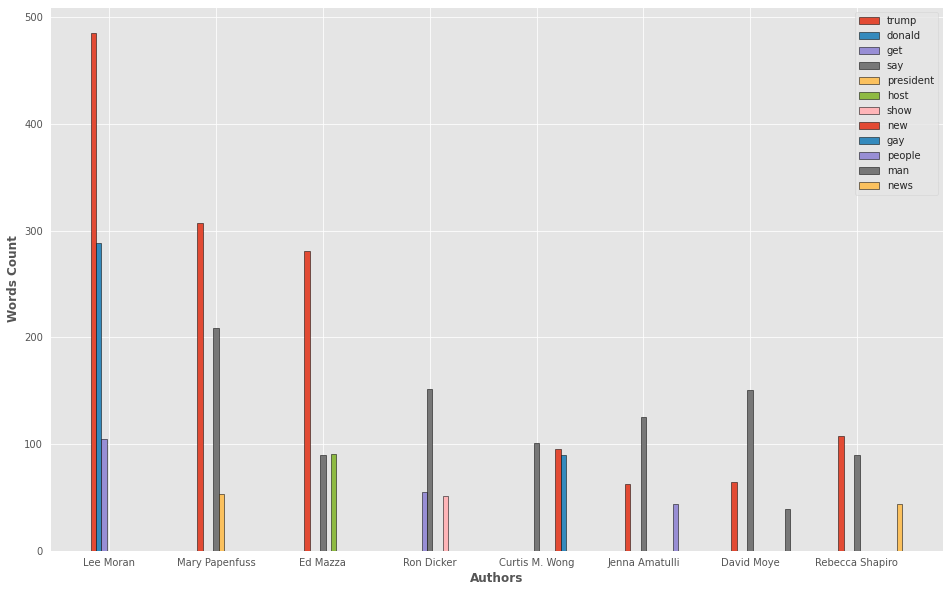

In [50]:
# Barplot FTW!!!
plot_bars_authors(words_df = word_df, authors_df = aut_words_df)

To conclude our analysis about authors, it is possible to see how the most frequent authors use a lot the word "trump" this might be due to the amount of samples in the category "politics". Therefore, it is very likely that most of the authors write for the category "politics". The author "Lee Moran" for example writes a lot about "politics" as can be seen by his top-3 most frequent words "trump", "donald" and "get". Another very common word used by most of the authors is "say", which might be used in a lot of categories. "Curtis M. Wong" is the unique frequent author who writes about "queer voices" as he is the only one employing the world "gay" in his writing style.

In a similar fashion as the analysis presented for the task 2, the authors have a very similar writing style and common words. There are a lot of authors but most of the samples are condensed between the top 10 authors, other authors might probably only write one article. Finally, it would be possible to train a model that giving an author's name the model would write a sentence. For example, giving the name "Lee Moran" the produced sentence will likely be of the category "politics".

## Fifth point

Basándote en el texto de la descripción corta, caracteriza este dataset.

To address this point I will analize the information provided in the feature `short_description` and then train a neural network model which will aim to classify the categories of the dataset giving `short_description` as features.

The first step is to visualize (again) the average lenght of the `short_description` text.

In [51]:
# Visualizing short description
# Use plotly to see the distribution of categorical data
# https://www.kaggle.com/vikashrajluhaniwal/recommending-news-articles-based-on-read-articles#6.-Headline-based-similarity-on-new-articles
fig = ff.create_distplot([news_category['short_description'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Description lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of Description",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500)
plotly.offline.plot(fig, filename = 'short_description.html')

'short_description.html'

As mentioned before, The text-lenght for the short_description feature is roughly 200 characters long. It is also possible to see that the text's average lenght in the headline and in the short_description are quite different. Generally, the text in the description is way longer and may provide more information for a classification task.

Now I will plot a wordcloud with the most frequent words in the `short_description` feature.

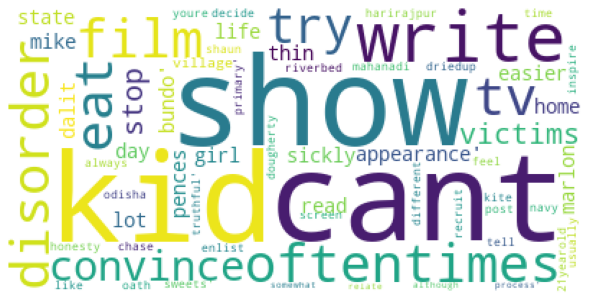

In [52]:
# Make a copy of the dataset
shortd_df = f_articles.copy()

text_description = shortd_df['short_description'].values 
wordcloud = WordCloud(max_words = 200, background_color ='white', stopwords = stop_words).generate(str(text_description))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

The Word Cloud shows how the word "show", "cant", "Kid" and "write" are oftenly used to describe the different categories in the dataset. It is important to recall that this text is very long and may have very different words, that is why I only plotted a maximum of 200 words. Ironically, the word "trump" is not here, which is surprising.

Now it is time to train a neural network to classify the dataset. Similar with the first task, the labels are the `category` but now the features are `short_description`. I will use one the model with Bidirectional LSTM as I am using less features compared with the first task and therefore, It is expected that this model works worse than the first one.

In [53]:
# Define targets and Labels
# Targets
seq_des = np.array([text for text in f_articles['short_description']])
# Labels
labels_des = np.array([label for label in f_articles['category']])

In [54]:
print(seq_des.shape)
print(seq_des[0])

(24274,)
oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance


In [55]:
# Encoding categories
label_encoder_des = LabelEncoder()
# Fir the encoder
labels_des = label_encoder_des.fit_transform(labels_des)

In [56]:
print('The lenght of the labels are: {}'.format(len(np.unique(labels_des))))
print('The labels are: {}'.format(np.unique(labels_des)))

The lenght of the labels are: 28
The labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [57]:
# Parameters
# Size of the vocabulary
vocab_size = 2000
# Dimmension of the embedding 
embedding_dim = 128
# LSTM dim
lstm_dim = 32
# hidden dim (fully connected)
hidden_dim = 64
# Maximum lenght of the tokenized vector
max_length = 120
# Padd the vector after the sequence
padding_type ='post'
# Used to replace out-of-vocabulary words
oov_tok = "<OOV>"

Similarly, the 30% of the dataset is splitted for valdiation after the training.

In [58]:
# split the dataset
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(seq_des, labels_des, 
                                                                                          test_size = 0.30, 
                                                                                          stratify = labels_des)

In [59]:
# Transform text into a vector
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fir to the train sequence
tokenizer.fit_on_texts(train_sentences)
# Dictionary with the index of each word
word_index = tokenizer.word_index

# Transform train dataset to sequence 
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# Pad the sequence to the desired shape (given above)
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)

# Vectorize and Padd validation dataset
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen = max_length)

### Model Definition

As mentioned before, I will use the model with a Bidirectional layer. a thorought description of this particular model can be seen in the first task.

In [60]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Flat Dimension
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)), # Output of LSTM is Batch x Net out x 2
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels_des)), activation='softmax')
])

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 128)          256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 28)                1820      
Total params: 303,196
Trainable params: 303,196
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
# Callback for early stopping after val stop improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
num_epochs = 50
history = model.fit(train_padded, train_labels, 
                    epochs = num_epochs, verbose=2, 
                    validation_split=0.33, callbacks= [early_stop])

# Predict over the validation test
pred_val = model.predict(validation_padded)
pred_val = np.array([np.argmax(i) for i in pred_val])

Epoch 1/50
356/356 - 6s - loss: 2.4074 - accuracy: 0.3792 - val_loss: 2.1995 - val_accuracy: 0.4183
Epoch 2/50
356/356 - 5s - loss: 2.0733 - accuracy: 0.4467 - val_loss: 2.0972 - val_accuracy: 0.4367
Epoch 3/50
356/356 - 6s - loss: 1.8915 - accuracy: 0.4882 - val_loss: 2.0672 - val_accuracy: 0.4504
Epoch 4/50
356/356 - 8s - loss: 1.7474 - accuracy: 0.5194 - val_loss: 2.0784 - val_accuracy: 0.4513
Epoch 5/50
356/356 - 10s - loss: 1.6205 - accuracy: 0.5502 - val_loss: 2.1393 - val_accuracy: 0.4481
Epoch 6/50
356/356 - 10s - loss: 1.5092 - accuracy: 0.5829 - val_loss: 2.2218 - val_accuracy: 0.4305


### Plotting results

Now is time to plot the same bunch of results presented in the task one but now for this particular model.

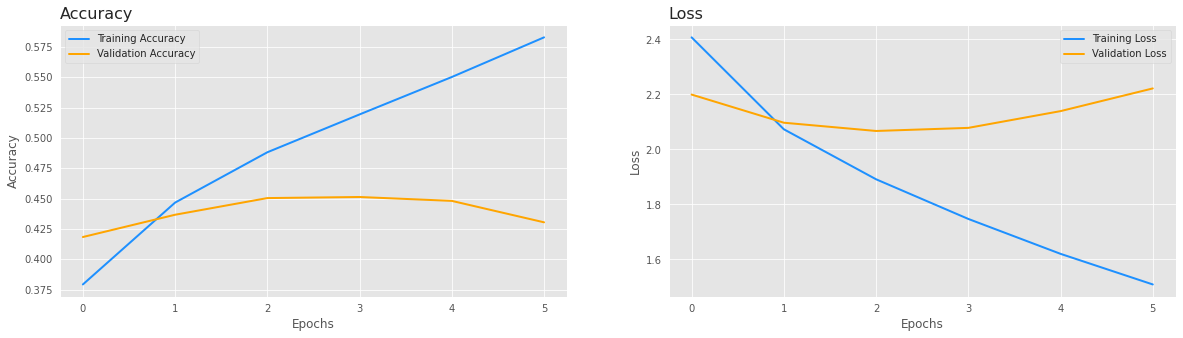

In [62]:
# Plotting the history of the model
plot_history(history)

This model has less performance (as expected) than the one that was fed with a bigger chain of text.

The overall training accuracy is: 0.421804201565289


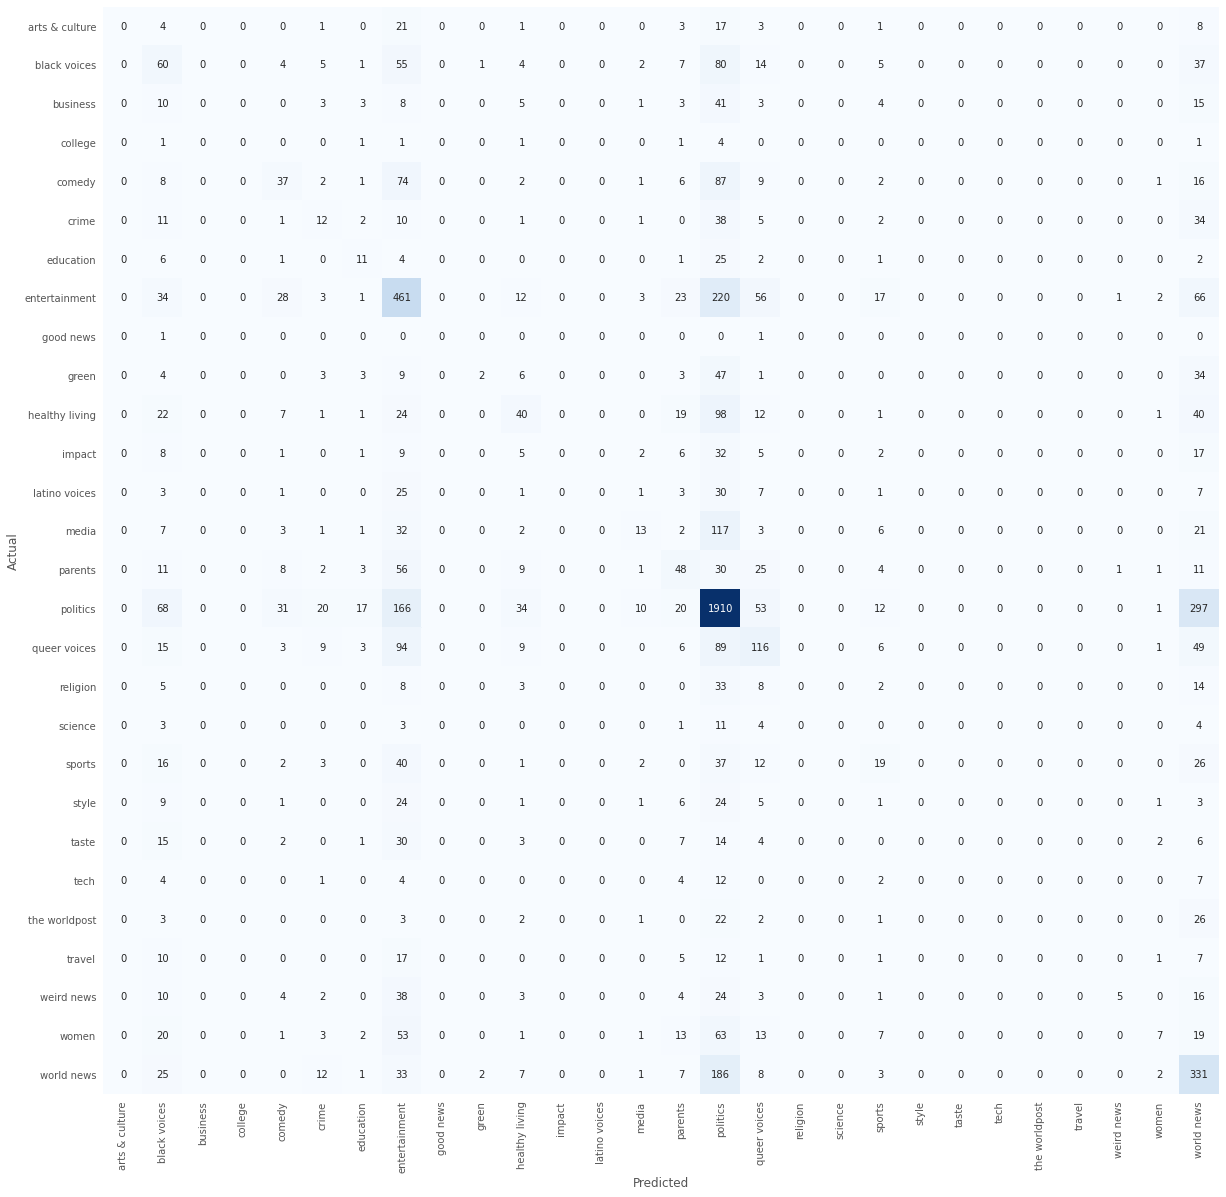

In [63]:
# Confusion matrix
# label_encoder.classes_ show the classes encoded
print('The overall training accuracy is: {}'.format(accuracy_score(pred_val, validation_labels)))
plot_cmatrix(pred_val, label_encoder_des.classes_, 20, validation_labels)

Visualizing the results in the confusion matrix it is possible to see how the best classified category still being "politics", followed by "world news" and so on. The model's performance is very poor and could be improved using complex models and preventing overfitting which happens a lot with the models I defined. Additionally, there are also categories that are never properly classified.

Now I will print the classification Metrics using Sklearn

In [64]:
# Printing all the metrics
print(classification_report(pred_val, validation_labels, target_names = label_encoder_des.classes_))

                precision    recall  f1-score   support

arts & culture       0.00      0.00      0.00         0
  black voices       0.22      0.15      0.18       393
      business       0.00      0.00      0.00         0
       college       0.00      0.00      0.00         0
        comedy       0.15      0.27      0.19       135
         crime       0.10      0.14      0.12        83
     education       0.21      0.21      0.21        53
 entertainment       0.50      0.35      0.41      1302
     good news       0.00      0.00      0.00         0
         green       0.02      0.40      0.03         5
healthy living       0.15      0.26      0.19       153
        impact       0.00      0.00      0.00         0
 latino voices       0.00      0.00      0.00         0
         media       0.06      0.32      0.10        41
       parents       0.23      0.24      0.24       198
      politics       0.72      0.58      0.64      3303
  queer voices       0.29      0.31      0.30  

/home/sherlock/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Finally, I will plot the percentage of accuracy per category as in the first task.

In [65]:
class_correct = list(0. for i in range(len(np.unique(labels_des))))
class_total = list(0. for i in range(len(np.unique(labels_des))))
# For loop to count the number of matches per class
for i in range(len(validation_labels)):
    # current target's label
    label = validation_labels[i]
    if validation_labels[i] == pred_val[i]:
        class_correct[label] += 1
    # Sum label
    class_total[label] += 1
        
for i in range(len(np.unique(labels_des))):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(label_encoder_des.classes_[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Accuracy of arts & culture:  0% ( 0/59)
Test Accuracy of black voices: 21% (60/275)
Test Accuracy of business:  0% ( 0/96)
Test Accuracy of college:  0% ( 0/10)
Test Accuracy of comedy: 15% (37/246)
Test Accuracy of crime: 10% (12/117)
Test Accuracy of education: 20% (11/53)
Test Accuracy of entertainment: 49% (461/927)
Test Accuracy of good news:  0% ( 0/ 2)
Test Accuracy of green:  1% ( 2/112)
Test Accuracy of healthy living: 15% (40/266)
Test Accuracy of impact:  0% ( 0/88)
Test Accuracy of latino voices:  0% ( 0/79)
Test Accuracy of media:  6% (13/208)
Test Accuracy of parents: 22% (48/210)
Test Accuracy of politics: 72% (1910/2639)
Test Accuracy of queer voices: 29% (116/400)
Test Accuracy of religion:  0% ( 0/73)
Test Accuracy of science:  0% ( 0/26)
Test Accuracy of sports: 12% (19/158)
Test Accuracy of style:  0% ( 0/76)
Test Accuracy of taste:  0% ( 0/84)
Test Accuracy of  tech:  0% ( 0/34)
Test Accuracy of the worldpost:  0% ( 0/60)
Test Accuracy of travel:  0% ( 0/54)
T

This leads us to the end of this point. To summarize, it is also possible to classify the dataset using only the `short_description`, however, the model is worse than the one developed with additional informatio (`headline`). this model could be improved with complex deep learning techniques as attention models watching always the overfitting! Additionally, a thorought analysis of the `short_description` feature was presented.

## Fourth Point

Ahora, utilizando técnicas de aprendizaje no supervisado, trata de identificar temas, “protagonistas” u otras entidades de las noticias.

This point is really interesting as unsupervised learning might provide insights about features that are not present in the dataset. To do so, I will use the KMeans model defining a number of clusters. More advanced techniques like agglomerative-based clustering ones might be used, however, I found this one useful. Additionally, an interesting approach would be thorugh Vararional Autoencoders. The aforementioned neural network might be trained to generate sequences of text by feeding it with sequences of text. This network will generate a compresion of the data and allow us to intuitively plot the data for further analysis.

To train the Kmeans classifier, I will first sort the dataframe.

**Note**: I will train the KMeans object with the whole sampled dataset. I do not aim to do any validation for this unsupervised task as this still a continuos area of research (How to measure performance of unsupervised models?). 

In [66]:
# Reset indexes
# # http://brandonrose.org/clustering
f_articles = f_articles.reset_index(drop=True)
f_articles.head()

,category,headline,authors,link,short_description,date,full_text
0,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18,to bone didnt teach glamour teach respect ofte...
1,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02,will grace creator donate gay bunny book every...
2,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31,we blood invisible live indias dalit women gir...
3,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19,wannacry ransomware attack raise alarm bell ci...
4,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20,walk dead reportedly cancel comiccon press eve...


The model will be feed with the `full_text` as features (again). This will result in a better clustering.

In [67]:
# Creating features and target
# Targets
seq_text = np.array([text for text in f_articles['full_text']])
# Labels
labels = np.array([label for label in f_articles['category']])

Now I will vectorize the words using `TfidfVectorizer` from Sklearn. This method transform raw text to a matrix of TF-IDF features. I decided to use this one as now on I will work with sklearn. Using sklearn methods might result in a comprehensible code.

In [68]:
# Now vectorize using Tfid
vectorizer = TfidfVectorizer(stop_words='english')
# Transform the 'full_text' string
X = vectorizer.fit_transform(seq_text)

### Training the KMeans model

The next line trains the KMeans model. I define 10 clusters as this result in a better clustering of the dataset. The initializaiton of the centroid is set as 'k-means++' which might produce a speed up convergence.

In [69]:
# Define number of Clusters
number_of_clusters = 10
# https://gertjanvandenburg.com/blog/autoencoder/
model = KMeans(n_clusters = number_of_clusters, 
               init = 'k-means++', 
               max_iter = 100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init = 1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
model.fit(X)

KMeans(max_iter=100, n_clusters=10, n_init=1)

The next cell arange the centroid by importance. This will be used ahead to print the cluster of a given text sequence.

In [70]:
# Obtain the indexes of the clusters' features from maximum to minumum (Most important features ahead)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# Obtain features' name
terms = vectorizer.get_feature_names()

It is very important to see the top-word of each cluster. To do so, the next cell prints the top-10 most frequent words of each one of the 10 clusters.

In [71]:
# Print most common words per cluster
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 make
 state
 know
 like
 come
 school
 years
 want
 day
 need
Cluster 1:
 trump
 donald
 president
 say
 administration
 tweet
 news
 russia
 make
 presidents
Cluster 2:
 people
 say
 kill
 trump
 want
 make
 lgbtq
 black
 young
 live
Cluster 3:
 health
 care
 tax
 gop
 senate
 republicans
 repeal
 obamacare
 plan
 cut
Cluster 4:
 sexual
 harassment
 misconduct
 assault
 allegations
 accuse
 women
 abuse
 say
 weinstein
Cluster 5:
 new
 york
 trump
 say
 city
 make
 state
 star
 report
 come
Cluster 6:
 white
 house
 trump
 say
 supremacists
 president
 charlottesville
 donald
 press
 supremacy
Cluster 7:
 time
 say
 trump
 day
 new
 make
 year
 want
 like
 state
Cluster 8:
 women
 week
 funniest
 men
 20
 womens
 black
 tweet
 say
 female
Cluster 9:
 say
 trump
 police
 want
 like
 make
 tell
 state
 hes
 man


To show that the model is working, I will feed the model with a text in the dataset and see in which cluster this text is placed.

In [72]:
# Text index
idx = 5
test_x = vectorizer.transform([f_articles['full_text'][idx]])
print('The text to process is: "{}"'.format(f_articles['full_text'][idx]))
cluster = model.predict(test_x)[0]
print("Text belongs to cluster number {0}".format(cluster))

The text to process is: "voter fraud executive order trump fraud democracy horrify disgust shameful word come mind president donald trump transparent attempt"
Text belongs to cluster number 1


From the last print I decided to define a new feature for the dataset called `main_topic`. This feature aims to synthetize the whole text in `full_text` to a unique word. This new feature might be used for a simpler classification task or to add more text features to the model. The feature is defined based on the main words of each cluster and there is going to be as much classes as clusters (10 in this case).

In [73]:
#s Set up colors per cluster
cluster_colors = {0: '#8B0000', 
                  1: '#FF8C00',
                  2: '#BC8F8F', 
                  3: '#7CFC00', 
                  4: '#E0FFFF',
                  5: '#008080', 
                  6: '#000000',
                  7: '#DA70D6', 
                  8: '#3CB371', 
                  9: '#708090'
                 }

# Clusters name (main_topic new feature)
cluster_names = {0: 'Desire', 
                 1: 'Health', 
                 2: 'State', 
                 3: 'Family', 
                 4: 'Violence',
                 5: 'Leisure', 
                 6: 'Diplomacy', 
                 7: 'Culture', 
                 8: 'News', 
                 9: 'Young',
                 }

    The following cells will create a new dataframe with this feature called `main_topic`. To do so, the text in `full_text` 

The following cells will create a new dataframe with this feature called `main_topic`. To do so, the text in `full_text` will be passed thorugh the KMeans model and the output label (cluster) will be assigned as one of the defined new classes.

In [74]:
topics = {'main_topic': []}
for whole_text in f_articles['full_text']:
    test_x = vectorizer.transform([whole_text])
    cluster_obt = model.predict(test_x)[0]
    topics['main_topic'].append(cluster_names[cluster_obt])

In [75]:
# Create dataframe out of dictionary
topics_df = pd.DataFrame.from_dict(topics)
# Concat the topics dataframe to the original one
final_df = pd.concat([f_articles, topics_df], axis=1, sort=False)
final_df.head()

,category,headline,authors,link,short_description,date,full_text,main_topic
0,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18,to bone didnt teach glamour teach respect ofte...,Desire
1,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02,will grace creator donate gay bunny book every...,Desire
2,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31,we blood invisible live indias dalit women gir...,News
3,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19,wannacry ransomware attack raise alarm bell ci...,Desire
4,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20,walk dead reportedly cancel comiccon press eve...,Desire


Above we can see the new dataset with a new column called `full_text`. This step of feature engineering is very important as it allow us to add new features to our dataset and probably, improve the performance of machine learning's models.

### Plotting

Now I will plot the words with its respective cluster. The words will be labeled with the `category` for analysis purposes. The next lines of code basically creates the KNearest model again but only with 500 feautes. This is done due to the amount of computaitons needed to do this plot.

In [84]:
# Create plot
# Targets
seq_text = np.array([text for text in f_articles['full_text']])
# Labels
labels = np.array([label for label in f_articles['category']])
# Slide through the vector
seq_text = seq_text[:500]
labels = labels[:500]

# Now vectorize using Tfid
vectorizer = TfidfVectorizer(stop_words='english')
# Transform the 'full_text' string
X = vectorizer.fit_transform(seq_text)

# Define number of Clusters
number_of_clusters = 10
# https://gertjanvandenburg.com/blog/autoencoder/
model = KMeans(n_clusters = number_of_clusters, 
               init = 'k-means++', 
               max_iter = 100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init = 1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
model.fit(X)

# Obtain the indexes of the clusters' features from maximum to minumum (Most important features ahead)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# Obtain features' name
terms = vectorizer.get_feature_names()

clusters = model.labels_.tolist()

In [89]:
X[0]

<1x3472 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

The next cell compares the distance between the words' vector. This is needed as similar vectors should be clustered closer. The distance metric used is cosine similarities.

In [85]:
# Comparing similarity between all the vectors
dist = 1 - cosine_similarity(X)

Additionally, I will use another unsupervised learning technique and this is PCA. PCA will allow me to reduce the dimensionality of the words' vectors. If this step is not performed, I would not be able to plot the words as the vectorized words' dimensionality is very high. Therefore, I decided to compress the vectors to only two principal components.

In [86]:
# Create and fit PCA model
pca = PCA(n_components=2)
pos = pca.fit_transform(dist) 

xs, ys = pos[:, 0], pos[:, 1]

In [87]:
# Make a copy of the labels
titles = labels.copy()

This final cell plots the words similarity labeled with the cluster and `category` of each word. This is a very important plot as might provide more information related to features. Additionally, with this image I may find intersection between `categories` and create unseen features or labels.

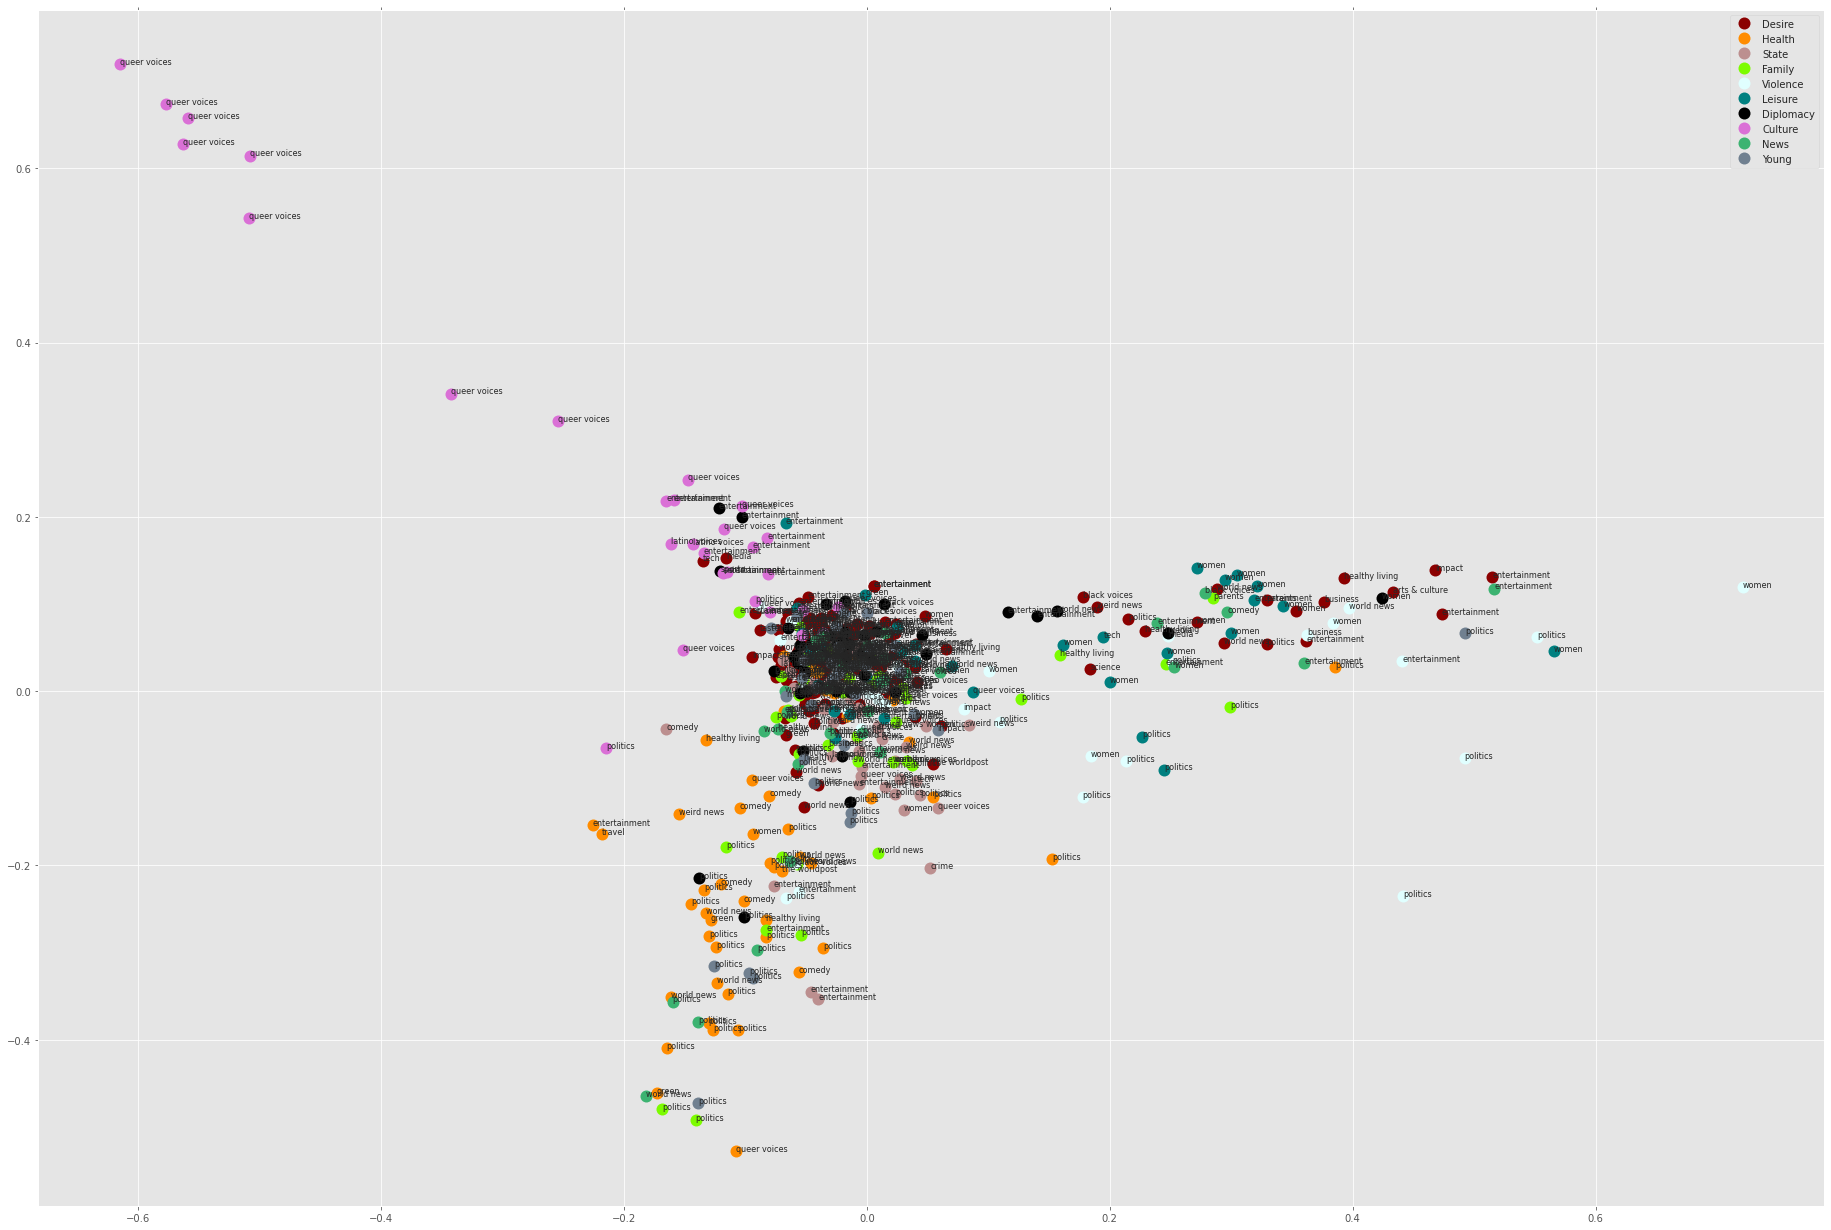

In [88]:
# Create new dataframe
# https://gertjanvandenburg.com/blog/autoencoder/
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

# group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(32, 22)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

# add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)

# Dendrogram?
plt.show() #show the plot

The previous plot showed the categories (text) and a cluster label (color). Despite the plot is difficult to read due to the categories' text, it is possible to see relations between the clusters and pre-defined categories. For example on the bottom of the plot it is possible to see most of points assigned with the cluster label `news` are related with the `category` "politics" which makes sense. Ironically, there are also orange circles below with the cluster label `health`. The aforementioned might means that the writing style used in the cluster category `news` and `health` is very similar and from there would be possible to create a new feature which blends this information. 

On the right it is also possible to see that most of the cluster labels `diplomacy` were assigned. It is interesting to note that ideally this cluster should be heavily related to the category `politics`, however, it is not.

Finally, In the middle of the plot are a lot of samples together, this might be due that most of the samples are of the `category` "politics", ending up with a lot of samples clustered together. Reducing the number of samples also reduces the number of points plotted, however, the samples together persist and few information could be extracted.

To summarize, the unsupervised learning techniques allow us to generate a new feature and analyze potential new features based on the clusters generated. Complex models might be used to improve the performance.

# Sixth point

¿Qué otra información útil se puede extraer de los datos?

I did not had enough time to solve this problem, but I would address it by doing more plots with the library [Facets](https://github.com/PAIR-code/facets). The plots provided by Facets might probably throw useful information about the dataset and how to improve the usage of features to outperform the models developed. The use of a Variational Autoencoder might potentially improve the clustering task and allow me to see another features in the dataset similar to [VAE](https://gertjanvandenburg.com/blog/autoencoder/).